In [1]:
from ctypes.wintypes import LPBYTE
from inspect import CORO_SUSPENDED
import tensorflow as tf
import cv2
import numpy as np
from segment import segment_characters
from utils.misc_utils import parse_anchors
from utils.nms_utils import gpu_nms
from utils.plot_utils import plot_one_box
from utils.data_aug import letterbox_resize
from model import yolov3
import matplotlib.pyplot as plt
import os

Metal device set to: Apple M1


2022-04-15 14:38:16.038600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-15 14:38:16.038723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/berkayucer/miniforge3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/berkayucer/miniforge3/envs/tf/lib/python3.8/site-packages/tf_slim/layers/layers.py:684: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `la

INFO:tensorflow:Restoring parameters from ./data/custom/yolov3.ckpt


2022-04-15 14:38:17.628121: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-15 14:38:17.628673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-15 14:38:18.026941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


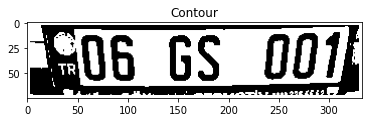

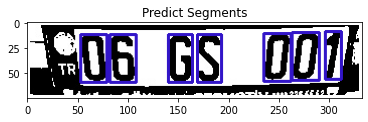

In [2]:
anchors = parse_anchors("./data/yolo_anchors.txt")
restore_path="./data/custom/yolov3.ckpt"
new_size=416
test_files_path='test_data/'
with tf.compat.v1.Session() as sess:
    input_data = tf.compat.v1.placeholder(tf.float32, [1, new_size, new_size, 3], name='input_data')
    yolo_model = yolov3(1, anchors)
    with tf.compat.v1.variable_scope('yolov3'):
        pred_feature_maps = yolo_model.forward(input_data, False)
    pred_boxes, pred_confs, pred_probs = yolo_model.predict(pred_feature_maps)
    pred_scores = pred_confs * pred_probs
    boxes, scores, labels = gpu_nms(pred_boxes, pred_scores, 1, max_boxes=200, score_thresh=0.3, nms_thresh=0.45)
    saver = tf.compat.v1.train.Saver()
    saver.restore(sess, restore_path)
    img_ori =cv2.imread('test_data/4.jpg')
    img, resize_ratio, dw, dh = letterbox_resize(img_ori, new_size, new_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.asarray(img, np.float32)
    img = img[np.newaxis, :] / 255.

    boxes_, scores_, labels_ = sess.run([boxes, scores, labels], feed_dict={input_data: img})
    boxes_[:, [0, 2]] = (boxes_[:, [0, 2]] - dw) / resize_ratio
    boxes_[:, [1, 3]] = (boxes_[:, [1, 3]] - dh) / resize_ratio
    for i in range(len(boxes_)):
        x0, y0, x1, y1 = boxes_[i]
        boxtemp=boxes_[0]
        x=int(boxtemp[0])
        y=int(boxtemp[1])
        w=int(boxtemp[2])
        h=int(boxtemp[3])
        crop=img_ori[y:h,x:w]
        lpText=segment_characters(crop)

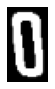

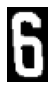

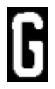

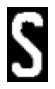

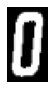

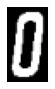

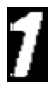

In [4]:
for i in range(len(lpText)):
    plt.subplot(1, len(lpText), i + 1)
    plt.imshow(lpText[i], cmap='gray')
    plt.axis('off')
    plt.show()



In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.layers import *

loaded_model = tf.keras.Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

loaded_model.load_weights('model/checkpointfile/')

2022-04-15 14:38:41.917519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-15 14:38:41.917572: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-15 14:38:41.942575: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open model/checkpointfile/: FAILED_PRECONDITION: model/checkpointfile; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [6]:
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img

In [7]:
def show_results(ret):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPRSTUVYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(lpText): 
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) 
        y_ =loaded_model.predict(img) 
        classes_x=np.argmax(y_,axis=1)[0] 
        character = dic[classes_x]
        output.append(character) 
        
    plate_number = ''.join(output)
    return plate_number

In [8]:
show_results(lpText)

2022-04-15 14:38:52.805235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


'06GS007'